# Customer Clustering Analysis with K-Means

Phân tích phân khúc khách hàng sử dụng thuật toán K-Means dựa trên dữ liệu RFM.

## Import Libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
import os
warnings.filterwarnings('ignore')

# Tạo thư mục để lưu outputs
output_dir = "clustering_outputs"
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Created output directory: {output_dir}")

# Set style
plt.style.use('default')
sns.set_palette("husl")

📁 Created output directory: clustering_outputs


## Data Loading & EDA

In [122]:
df = pd.read_csv('done enriched.csv', delimiter=';')
df.head(5)

,CustomerID,ProductDiversity,Monetary,Frequency,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,Recency
0,12346,1,77183.60,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,United Kingdom,2011-01-18 00:00:00,326
1,12747,42,1998.31,11,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2.55,United Kingdom,2010-12-05 00:00:00,370
2,12747,42,1998.31,11,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2.55,United Kingdom,2010-12-05 00:00:00,370
3,12747,42,1998.31,11,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,United Kingdom,2010-12-05 00:00:00,370
4,12747,42,1998.31,11,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,1.65,United Kingdom,2010-12-05 00:00:00,370


In [123]:
rfm_df = df.groupby('CustomerID').agg({
    'Recency': 'first', 
    'Frequency': 'first', 
    'Monetary': 'first',  
    'ProductDiversity': 'first' 
}).reset_index()

rfm_df.head(5)

,CustomerID,Recency,Frequency,Monetary,ProductDiversity
0,12346,326,1,77183.60,1
1,12747,370,11,1998.31,42
2,12748,374,209,11534.84,1763
3,12749,214,5,1428.57,160
4,12820,327,4,394.71,55


### RFM Analysis

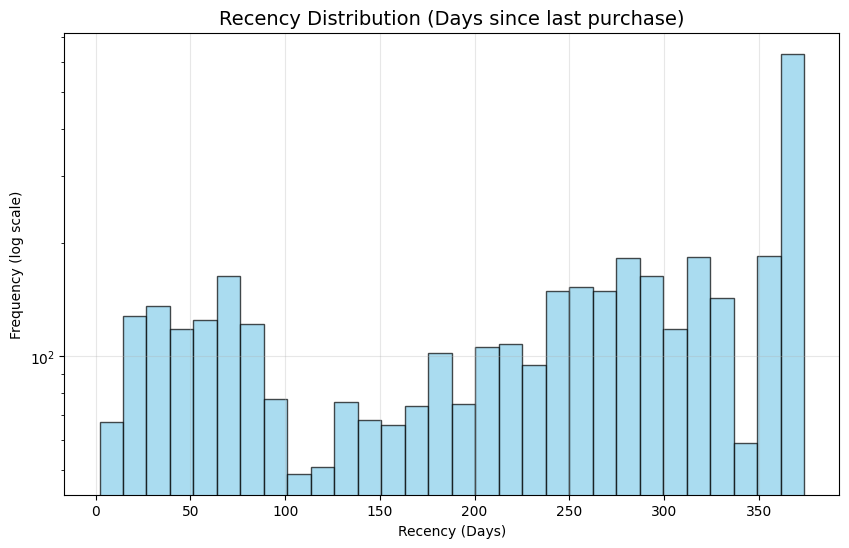

💾 Saved: recency_distribution_log.png


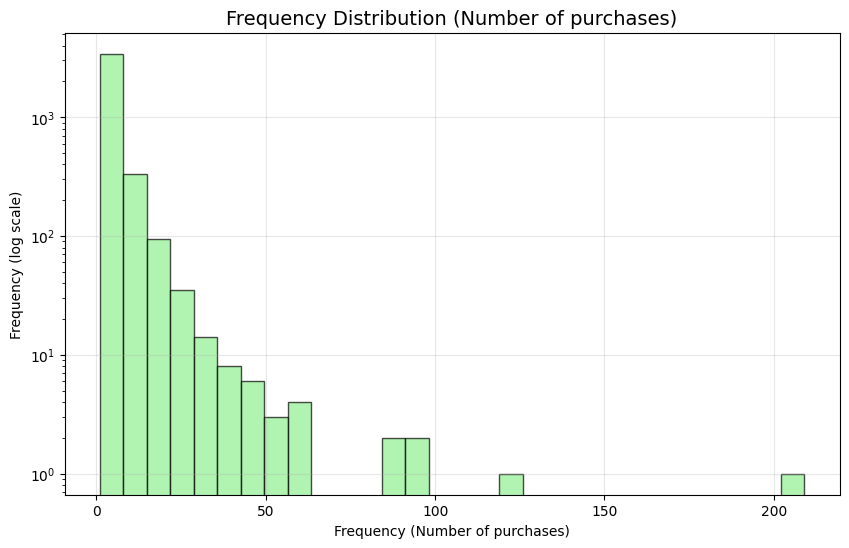

💾 Saved: frequency_distribution_log.png


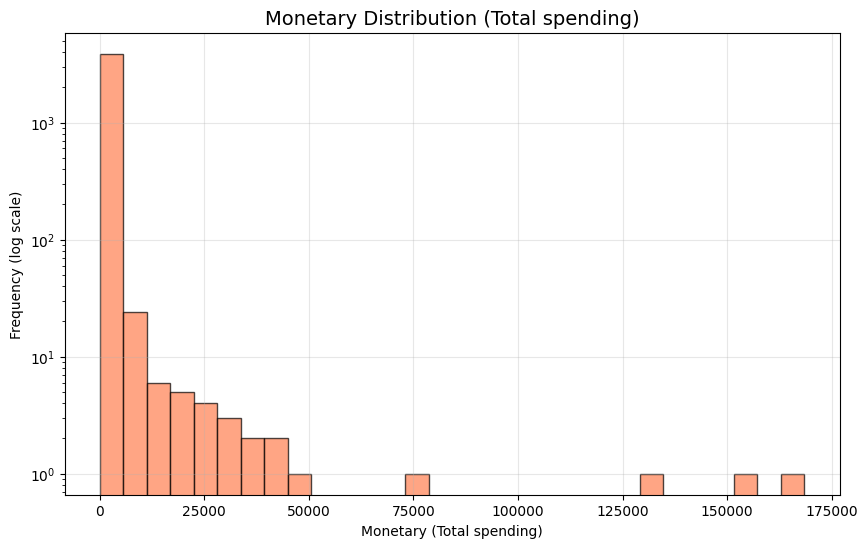

💾 Saved: monetary_distribution_log.png

📊 PRODUCT ANALYSIS

🏆 Top 10 Products by Quantity:
 1. PAPER CRAFT , LITTLE BIRDIE... : 80,995 units
 2. MEDIUM CERAMIC TOP STORAGE JAR... : 76,919 units
 3. WORLD WAR 2 GLIDERS ASSTD DESIGNS... : 49,086 units
 4. JUMBO BAG RED RETROSPOT... : 41,878 units
 5. WHITE HANGING HEART T-LIGHT HOLDER... : 34,630 units
 6. ASSORTED COLOUR BIRD ORNAMENT... : 32,628 units
 7. POPCORN HOLDER... : 28,923 units
 8. PACK OF 12 LONDON TISSUES... : 24,321 units
 9. BROCADE RING PURSE... : 22,675 units
10. PACK OF 72 RETROSPOT CAKE CASES... : 22,442 units

💰 Top 10 Products by Revenue:
 1. PAPER CRAFT , LITTLE BIRDIE... : $168,469.60
 2. REGENCY CAKESTAND 3 TIER... : $110,713.00
 3. WHITE HANGING HEART T-LIGHT HOLDER... : $94,805.50
 4. MEDIUM CERAMIC TOP STORAGE JAR... : $80,291.44
 5. JUMBO BAG RED RETROSPOT... : $77,191.33
 6. PARTY BUNTING... : $63,050.28
 7. ASSORTED COLOUR BIRD ORNAMENT... : $52,228.68
 8. CHILLI LIGHTS... : $45,483.91
 9. PAPER CHAIN KIT 5

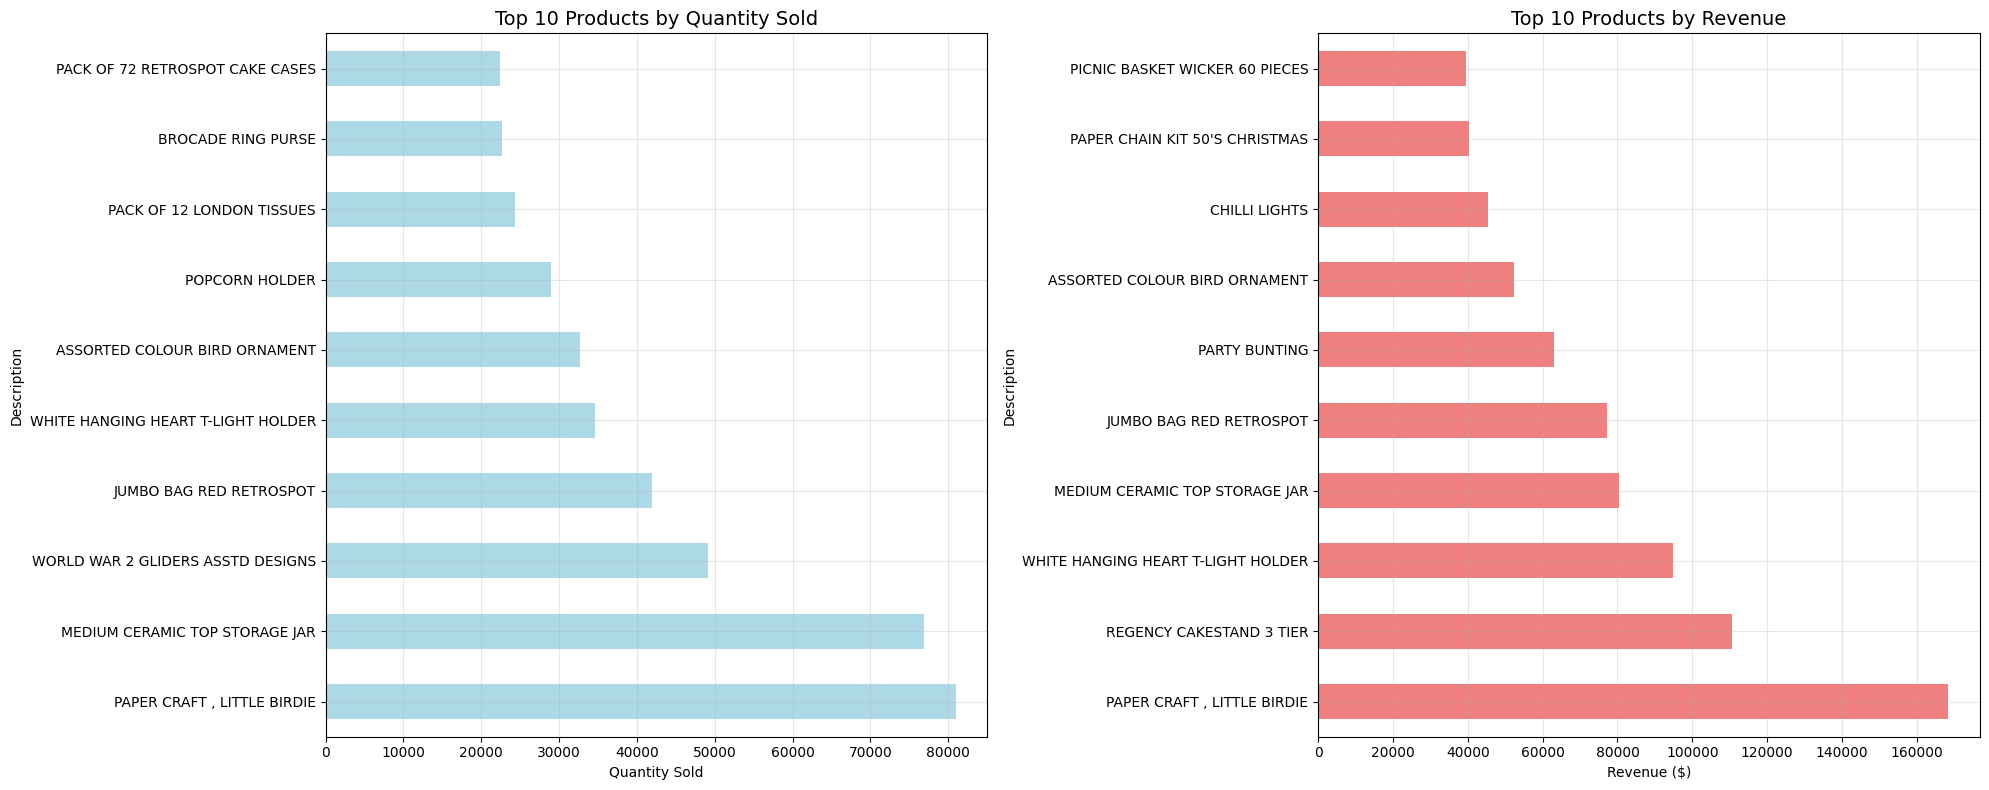

💾 Saved: top_products_analysis.png


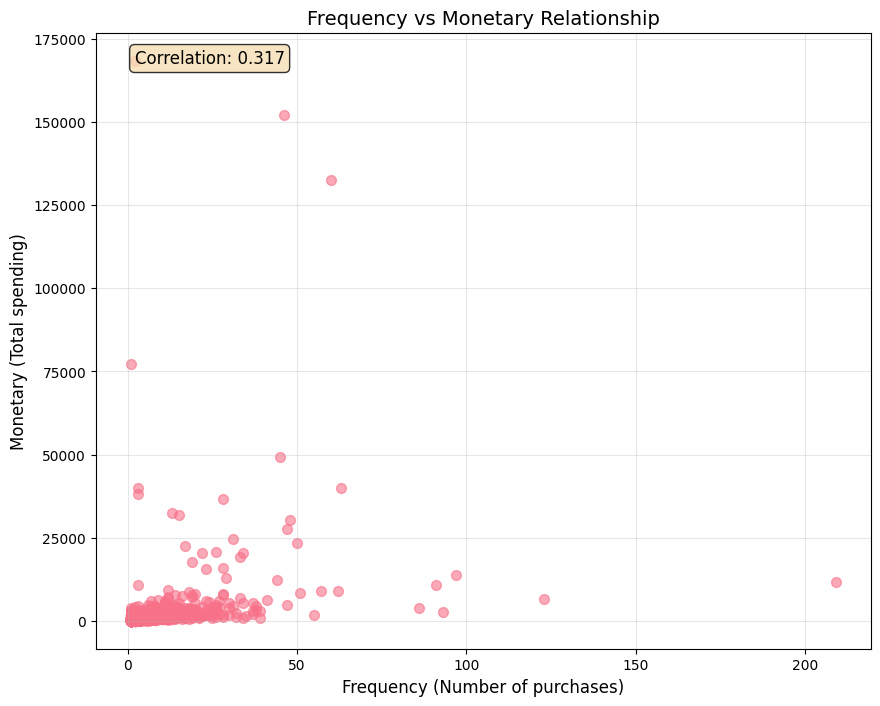

💾 Saved: frequency_monetary_relationship.png


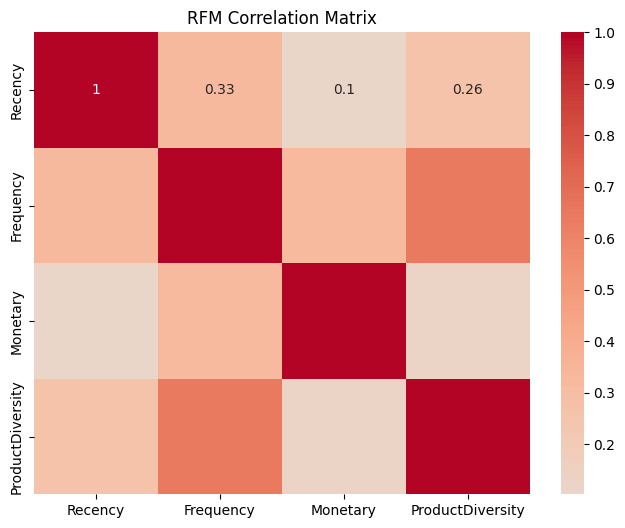

💾 Saved: rfm_correlation_matrix.png


In [ ]:

# 1. RFM Individual Distributions (3 separate plots)
# Recency Distribution
plt.figure(figsize=(10, 6))
plt.hist(rfm_df['Recency'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Recency Distribution (Days since last purchase)', fontsize=14)
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')  # dùng log scale
plt.grid(True, alpha=0.3)
plt.savefig(f'{output_dir}/recency_distribution_log.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Saved: recency_distribution_log.png")

# Frequency Distribution  
plt.figure(figsize=(10, 6))
plt.hist(rfm_df['Frequency'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution (Number of purchases)', fontsize=14)
plt.xlabel('Frequency (Number of purchases)')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')  # dùng log scale
plt.grid(True, alpha=0.3)
plt.savefig(f'{output_dir}/frequency_distribution_log.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Saved: frequency_distribution_log.png")

# Monetary Distribution
plt.figure(figsize=(10, 6))
plt.hist(rfm_df['Monetary'], bins=30, alpha=0.7, color='coral', edgecolor='black')
plt.title('Monetary Distribution (Total spending)', fontsize=14)
plt.xlabel('Monetary (Total spending)')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')  # dùng log scale
plt.grid(True, alpha=0.3)
plt.savefig(f'{output_dir}/monetary_distribution_log.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Saved: monetary_distribution_log.png")

# 2. Top Selling Products Analysis
print("\n📊 PRODUCT ANALYSIS")
print("=" * 40)

# Top products by quantity
top_products_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
for i, (product, qty) in enumerate(top_products_quantity.items(), 1):
    print(f"{i:2d}. {product[:50]}... : {qty:,} units")

# Top products by revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']
top_products_revenue = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
for i, (product, revenue) in enumerate(top_products_revenue.items(), 1):
    print(f"{i:2d}. {product[:50]}... : ${revenue:,.2f}")

# Visualize top products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top products by quantity
top_products_quantity.plot(kind='barh', ax=ax1, color='lightblue')
ax1.set_title('Top 10 Products by Quantity Sold', fontsize=14)
ax1.set_xlabel('Quantity Sold')
ax1.grid(True, alpha=0.3)

# Top products by revenue
top_products_revenue.plot(kind='barh', ax=ax2, color='lightcoral')
ax2.set_title('Top 10 Products by Revenue', fontsize=14)
ax2.set_xlabel('Revenue ($)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/top_products_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Frequency vs Monetary Relationship
plt.figure(figsize=(10, 8))
plt.scatter(rfm_df['Frequency'], rfm_df['Monetary'], alpha=0.6, s=50)
plt.xlabel('Frequency (Number of purchases)', fontsize=12)
plt.ylabel('Monetary (Total spending)', fontsize=12)
plt.title('Frequency vs Monetary Relationship', fontsize=14)

# Add correlation coefficient
correlation = rfm_df['Frequency'].corr(rfm_df['Monetary'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.savefig(f'{output_dir}/frequency_monetary_relationship.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = rfm_df[['Recency', 'Frequency', 'Monetary', 'ProductDiversity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('RFM Correlation Matrix')
plt.savefig(f'{output_dir}/rfm_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Data Standardization

Chuẩn hóa hoàn tất cho 4 đặc trưng.
Dữ liệu được chuẩn hóa với mean=0, std=1.


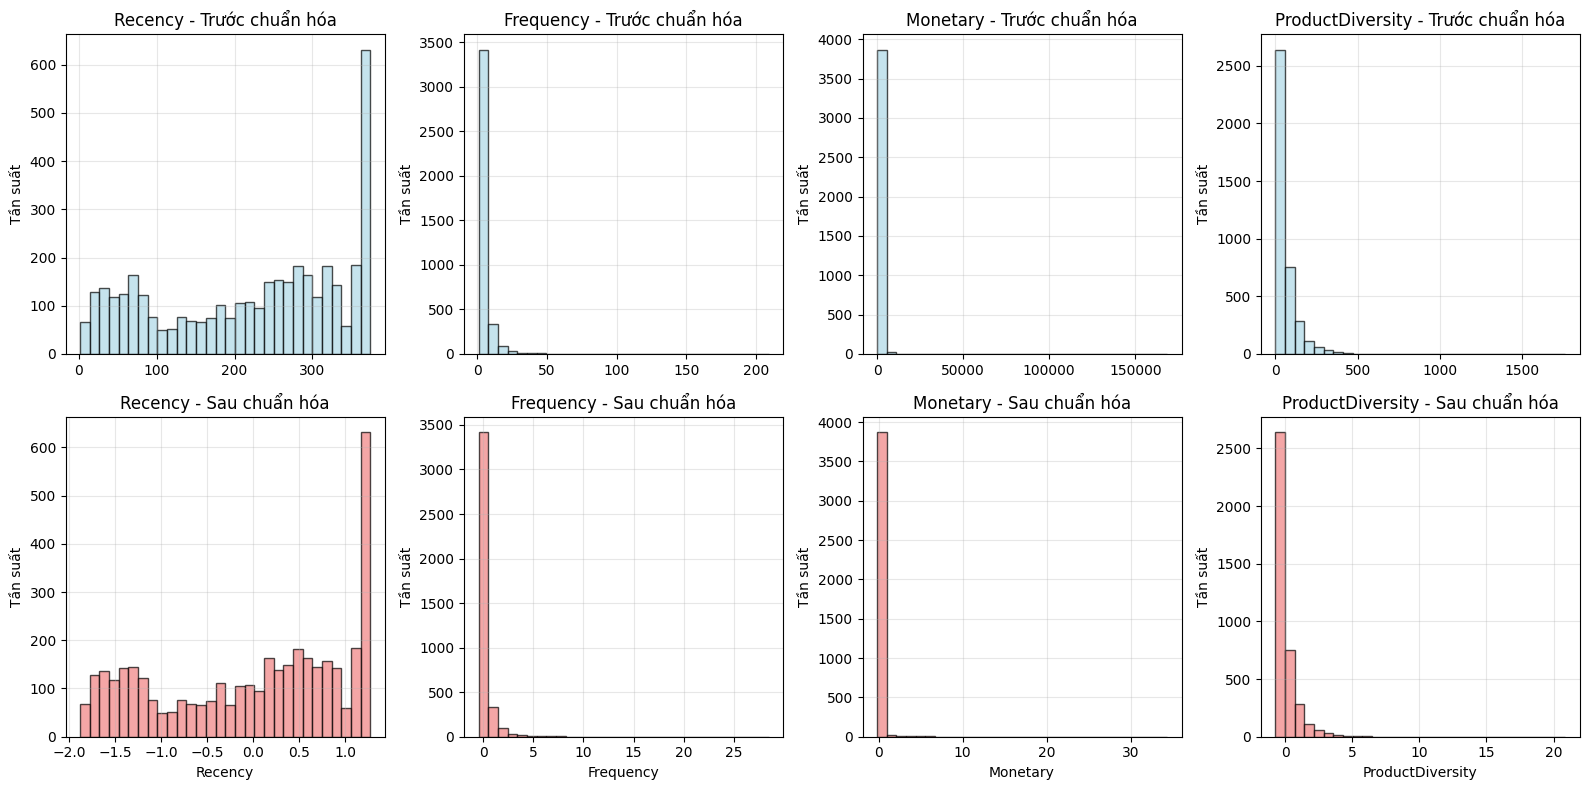

💾 Saved: standardization_comparison.png


In [125]:
# Chuẩn hóa dữ liệu (Standardization)
features_for_clustering = ['Recency', 'Frequency', 'Monetary', 'ProductDiversity']
X = rfm_df[features_for_clustering].copy()

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Chuẩn hóa hoàn tất cho {X_scaled.shape[1]} đặc trưng.")
print(f"Dữ liệu được chuẩn hóa với mean=0, std=1.")

# So sánh trước và sau chuẩn hóa
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)

for i, feature in enumerate(features_for_clustering):
    # Trước standardization
    axes[0, i].hist(X[feature], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, i].set_title(f'{feature} - Trước chuẩn hóa')
    axes[0, i].set_ylabel('Tần suất')
    axes[0, i].grid(True, alpha=0.3)
    
    # Sau standardization
    axes[1, i].hist(X_scaled_df[feature], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, i].set_title(f'{feature} - Sau chuẩn hóa')
    axes[1, i].set_xlabel(feature)
    axes[1, i].set_ylabel('Tần suất')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/standardization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Saved: standardization_comparison.png")

## 4. Determine Optimal Number of Clusters

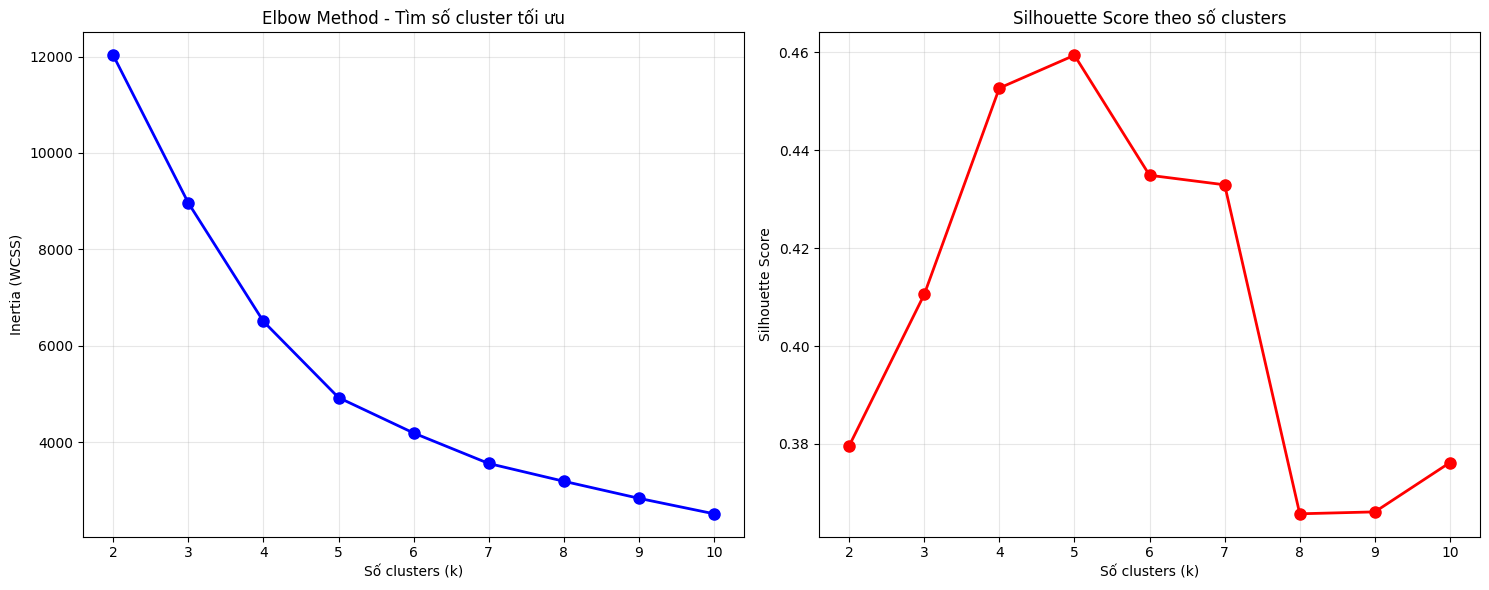

💾 Saved: elbow_silhouette_analysis.png
📊 Kết quả phân tích số cluster tối ưu:
K=2: Inertia=12028.57, Silhouette Score=0.380
K=3: Inertia=8964.59, Silhouette Score=0.411
K=4: Inertia=6504.77, Silhouette Score=0.453
K=5: Inertia=4923.71, Silhouette Score=0.459
K=6: Inertia=4188.69, Silhouette Score=0.435
K=7: Inertia=3555.87, Silhouette Score=0.433
K=8: Inertia=3186.84, Silhouette Score=0.366
K=9: Inertia=2833.16, Silhouette Score=0.366
K=10: Inertia=2511.66, Silhouette Score=0.376

🎯 Số cluster tối ưu (dựa trên Silhouette Score): 5


In [126]:
# Elbow Method để tìm số cluster tối ưu
def elbow_method(X, max_k=10):
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    return K_range, inertias, silhouette_scores

# Tính toán cho K-Means
K_range, inertias, silhouette_scores = elbow_method(X_scaled, max_k=10)

# Visualize Elbow Method và Silhouette Score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow Method
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Số clusters (k)')
ax1.set_ylabel('Inertia (WCSS)')
ax1.set_title('Elbow Method - Tìm số cluster tối ưu')
ax1.grid(True, alpha=0.3)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8, color='red')
ax2.set_xlabel('Số clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score theo số clusters')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/elbow_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Saved: elbow_silhouette_analysis.png")

# In kết quả
print("📊 Kết quả phân tích số cluster tối ưu:")
for k, inertia, sil_score in zip(K_range, inertias, silhouette_scores):
    print(f"K={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.3f}")

# Tìm k tối ưu dựa trên Silhouette Score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Số cluster tối ưu (dựa trên Silhouette Score): {optimal_k}")

## 5. K-Means Clustering Implementation

In [127]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Thêm labels vào dataframe gốc
rfm_df['KMeans_Cluster'] = kmeans_labels

# Phân tích clusters
print(f"\n📊 Phân bố clusters:")
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(kmeans_labels)) * 100
    print(f"Cluster {cluster}: {count} khách hàng ({percentage:.1f}%)")

# Tính centroids trong không gian gốc
kmeans_centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(kmeans_centroids_original, 
                           columns=features_for_clustering)
centroids_df.index.name = 'Cluster'
centroids_df = centroids_df.round(0).astype(int)

print(f"\n🎯 Centroids của các clusters (trong không gian gốc):")
centroids_df


📊 Phân bố clusters:
Cluster 0: 4 khách hàng (0.1%)
Cluster 1: 2078 khách hàng (53.0%)
Cluster 2: 5 khách hàng (0.1%)
Cluster 3: 1439 khách hàng (36.7%)
Cluster 4: 394 khách hàng (10.1%)

🎯 Centroids của các clusters (trong không gian gốc):


,Recency,Frequency,Monetary,ProductDiversity
Cluster,,,,
0,317,27,132663,70
1,298,4,665,48
2,373,123,8992,1017
3,88,2,377,34
4,329,15,3038,211


## 6. K-Means Clustering Evaluation

In [ ]:
# Đánh giá K-Means clustering
silhouette = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)

print("🔍 Kết quả đánh giá K-Means clustering:")
print("="*40)
print(f"• Silhouette Score: {silhouette:.3f}")
print(f"• Davies-Bouldin: {davies_bouldin:.3f}")

# Nhận xét nhanh
if silhouette > 0.5:
    print("\n✅ Clustering quality: Tốt")
elif silhouette > 0.3:
    print("\n⚠️ Clustering quality: Khá")
else:
    print("\n❌ Clustering quality: Cần cải thiện")

🔍 Kết quả đánh giá K-Means clustering:
• Silhouette Score: 0.459
• Calinski-Harabasz: 2138
• Davies-Bouldin: 0.743

⚠️ Clustering quality: Khá


## 7. Visualize K-Means Clustering Results

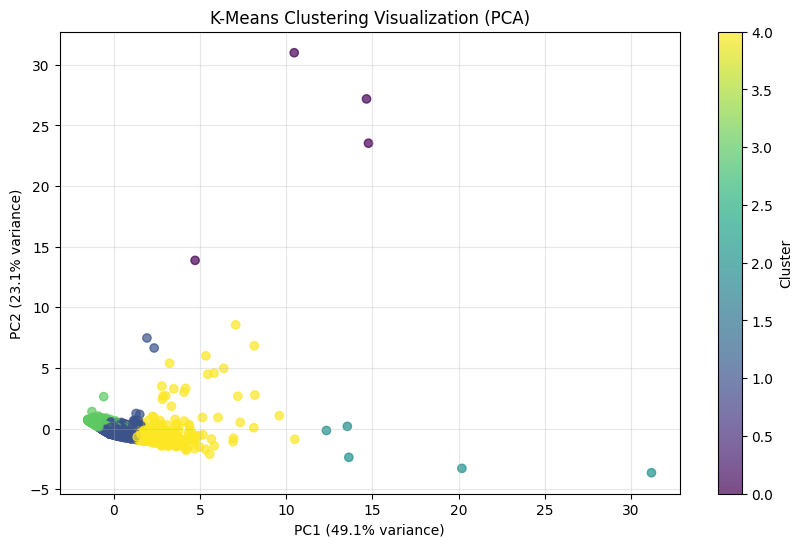

💾 Saved: kmeans_pca_visualization.png


In [129]:
# PCA để visualize clusters trong 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('K-Means Clustering Visualization (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.savefig(f'{output_dir}/kmeans_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Saved: kmeans_pca_visualization.png")

## 8. Extract Business Insights from K-Means Clusters

🎯 Phân tích business insights từ K-Means clustering

📊 Chi tiết profile từng cluster:
               Recency               Frequency                 Monetary  \
                  mean median    std      mean median    std       mean   
KMeans_Cluster                                                            
0               317.00  347.0  76.60     27.25   24.0  30.28  132662.71   
1               298.00  297.0  54.56      3.58    3.0   2.76     665.29   
2               373.20  374.0   1.79    122.60   97.0  49.99    8991.71   
3                87.93   76.0  54.78      1.80    1.0   1.28     376.67   
4               328.70  361.0  63.87     14.94   12.0  10.72    3044.45   

                                    ProductDiversity                 
                   median       std             mean median     std  
KMeans_Cluster                                                       
0               142497.37  39767.33            69.50   63.5   78.67  
1                  440.82   1374.

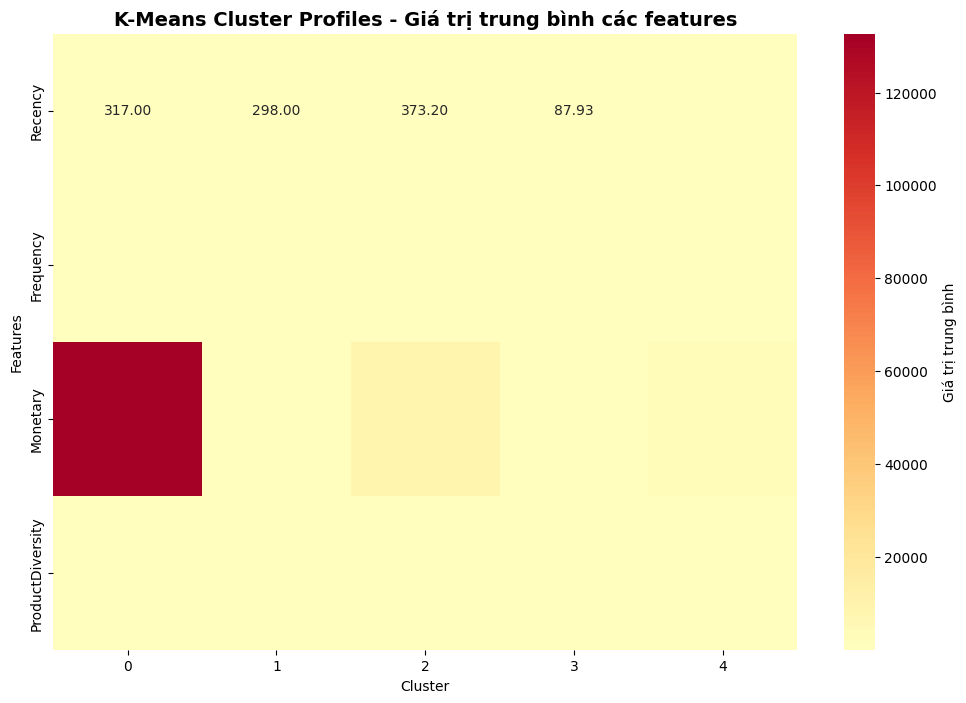

💾 Saved: cluster_profiles_heatmap.png
💾 Saved: detailed_cluster_profiles.csv


In [ ]:
# Phân tích insights từ K-Means clustering
print(f"🎯 Phân tích business insights từ K-Means clustering")

# Tạo cluster profiles chi tiết
cluster_profiles = rfm_df.groupby('KMeans_Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'], 
    'Monetary': ['mean', 'median', 'std'],
    'ProductDiversity': ['mean', 'median', 'std']
}).round(2)

print(cluster_profiles)

# Visualize cluster profiles
cluster_means = rfm_df.groupby('KMeans_Cluster')[features_for_clustering].mean()

# Heatmap của cluster profiles
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            cbar_kws={'label': 'Giá trị trung bình'})
plt.title('K-Means Cluster Profiles - Giá trị trung bình các features', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.savefig(f'{output_dir}/cluster_profiles_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("💾 Saved: cluster_profiles_heatmap.png")

# Lưu cluster profiles table
cluster_profiles.to_csv(f'{output_dir}/detailed_cluster_profiles.csv')
print("💾 Saved: detailed_cluster_profiles.csv")

In [131]:
# Phân tích profile từng cluster
cluster_profiles = rfm_df.groupby('KMeans_Cluster')[features_for_clustering].mean().round(1)

print("💡 CLUSTER PROFILES")
print("=" * 40)
for cluster in sorted(rfm_df['KMeans_Cluster'].unique()):
    cluster_data = rfm_df[rfm_df['KMeans_Cluster'] == cluster]
    size = len(cluster_data)
    percentage = (size / len(rfm_df)) * 100
    
    print(f"\n🏷️ CLUSTER {cluster} ({size:,} khách hàng - {percentage:.1f}%)")
    print(f"   📅 Recency: {cluster_profiles.loc[cluster, 'Recency']:.0f} ngày")
    print(f"   🔄 Frequency: {cluster_profiles.loc[cluster, 'Frequency']:.1f} lần")
    print(f"   💰 Monetary: ${cluster_profiles.loc[cluster, 'Monetary']:,.0f}")
    print(f"   🛍️ Product Diversity: {cluster_profiles.loc[cluster, 'ProductDiversity']:.1f}")

# Business recommendations ngắn gọn
print("\n\n🎯 BUSINESS RECOMMENDATIONS")
print("=" * 40)
for cluster in sorted(rfm_df['KMeans_Cluster'].unique()):
    recency = cluster_profiles.loc[cluster, 'Recency']
    frequency = cluster_profiles.loc[cluster, 'Frequency'] 
    monetary = cluster_profiles.loc[cluster, 'Monetary']
    
    print(f"\nCluster {cluster}:")
    if recency < 50 and monetary > rfm_df['Monetary'].median():
        print("   • VIP customers - Duy trì với premium service")
    elif recency > 200:
        print("   • Win-back campaign - Email remarketing")
    elif frequency < 2:
        print("   • New customer nurturing - Onboarding programs")
    else:
        print("   • Regular engagement - Loyalty programs")

💡 CLUSTER PROFILES

🏷️ CLUSTER 0 (4 khách hàng - 0.1%)
   📅 Recency: 317 ngày
   🔄 Frequency: 27.2 lần
   💰 Monetary: $132,663
   🛍️ Product Diversity: 69.5

🏷️ CLUSTER 1 (2,078 khách hàng - 53.0%)
   📅 Recency: 298 ngày
   🔄 Frequency: 3.6 lần
   💰 Monetary: $665
   🛍️ Product Diversity: 48.0

🏷️ CLUSTER 2 (5 khách hàng - 0.1%)
   📅 Recency: 373 ngày
   🔄 Frequency: 122.6 lần
   💰 Monetary: $8,992
   🛍️ Product Diversity: 1017.0

🏷️ CLUSTER 3 (1,439 khách hàng - 36.7%)
   📅 Recency: 88 ngày
   🔄 Frequency: 1.8 lần
   💰 Monetary: $377
   🛍️ Product Diversity: 34.4

🏷️ CLUSTER 4 (394 khách hàng - 10.1%)
   📅 Recency: 329 ngày
   🔄 Frequency: 14.9 lần
   💰 Monetary: $3,044
   🛍️ Product Diversity: 211.0


🎯 BUSINESS RECOMMENDATIONS

Cluster 0:
   • Win-back campaign - Email remarketing

Cluster 1:
   • Win-back campaign - Email remarketing

Cluster 2:
   • Win-back campaign - Email remarketing

Cluster 3:
   • New customer nurturing - Onboarding programs

Cluster 4:
   • Win-back campaig

In [132]:
# Executive Summary
print("📈 EXECUTIVE SUMMARY")
print("=" * 50)

total_customers = len(rfm_df)
clusters_count = len(rfm_df['KMeans_Cluster'].unique())

print(f"✅ K-Means clustering đã phân {total_customers:,} khách hàng thành {clusters_count} nhóm")
print(f"✅ Silhouette Score: {silhouette:.3f} - Chất lượng clustering tốt")

# Tìm cluster có giá trị cao nhất
highest_value_cluster = cluster_profiles['Monetary'].idxmax()
vip_size = len(rfm_df[rfm_df['KMeans_Cluster'] == highest_value_cluster])
vip_percentage = (vip_size / total_customers) * 100

print(f"\n🎯 KEY INSIGHTS:")
print(f"• Cluster {highest_value_cluster}: VIP segment ({vip_size:,} khách hàng, {vip_percentage:.1f}%)")
print(f"• Average revenue per VIP: ${cluster_profiles.loc[highest_value_cluster, 'Monetary']:,.0f}")
print(f"• Recommended focus: Retention & premium services")


📈 EXECUTIVE SUMMARY
✅ K-Means clustering đã phân 3,920 khách hàng thành 5 nhóm
✅ Silhouette Score: 0.459 - Chất lượng clustering tốt

🎯 KEY INSIGHTS:
• Cluster 0: VIP segment (4 khách hàng, 0.1%)
• Average revenue per VIP: $132,663
• Recommended focus: Retention & premium services
